In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd


In [4]:
def ScreenCoord2AngularCoord(ScreenCoord):
    # Inverse transformation of screen coords (0-1) to angular coords (degrees).

    # Parameters of the Hmd (HTC Vive).
    # Vertical FOV.
    VerticalFov = math.pi * 110 / 180
    # Size of a half screen.
    ScreenWidth = 1080
    ScreenHeight = 1200
    # The pixel distance between the eye and the screen center.
    ScreenDist = 0.5 * ScreenHeight / math.tan(VerticalFov / 2)

    AngularCoord = np.zeros(2)

    # The X coord.
    AngularCoord[0] = (math.atan((ScreenCoord[0] - 0.5) * ScreenWidth / ScreenDist) * 180) / math.pi
    # The Y coord.
    AngularCoord[1] = (math.atan((ScreenCoord[1] - 0.5) * ScreenHeight / ScreenDist) * 180) / math.pi

    return AngularCoord

In [21]:
def visualise_eh_task_data(file_path):
    data = np.loadtxt(file_path, delimiter='\t', usecols=(1, 4, 5), max_rows=1200)
    # Extract relevant columns
    frame_numbers = data[:, 0]
    print(frame_numbers)
    screen_coords = data[:, 1:3]
    print(screen_coords)
    
    angular_coords = np.empty_like(screen_coords)
    
    # Convert ScreenCoord to AngularCoord
    for i in range(len(screen_coords)):
        angular_coords[i] = ScreenCoord2AngularCoord(screen_coords[i])
            
    # Create plots
    plt.figure(figsize=(12, 6))
    
    # Plot pixel values (ScreenCoord)
    plt.subplot(1, 2, 1)
    plt.plot(frame_numbers, screen_coords[:, 0], label='X Coordinate', marker='o')
    plt.plot(frame_numbers, screen_coords[:, 1], label='Y Coordinate', marker='o')
    plt.xlabel('Frame Number')
    plt.ylabel('Screen Coordinates')
    plt.title('Pixel Values (ScreenCoord)')
    plt.legend()
    
    # Plot Angular Coordinates
    plt.subplot(1, 2, 2)
    plt.plot(frame_numbers, angular_coords[:, 0], label='x_dva', marker='o')
    plt.plot(frame_numbers, angular_coords[:, 1], label='y_dva', marker='o')
    plt.xlabel('Frame Number')
    plt.ylabel('Angular Coordinates')
    plt.title('Angular Coordinates')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    

[  1.   1.   2. ... 360. 361. 361.]
[[0.51 0.5 ]
 [0.51 0.5 ]
 [0.51 0.5 ]
 ...
 [0.53 0.48]
 [0.53 0.48]
 [0.53 0.48]]


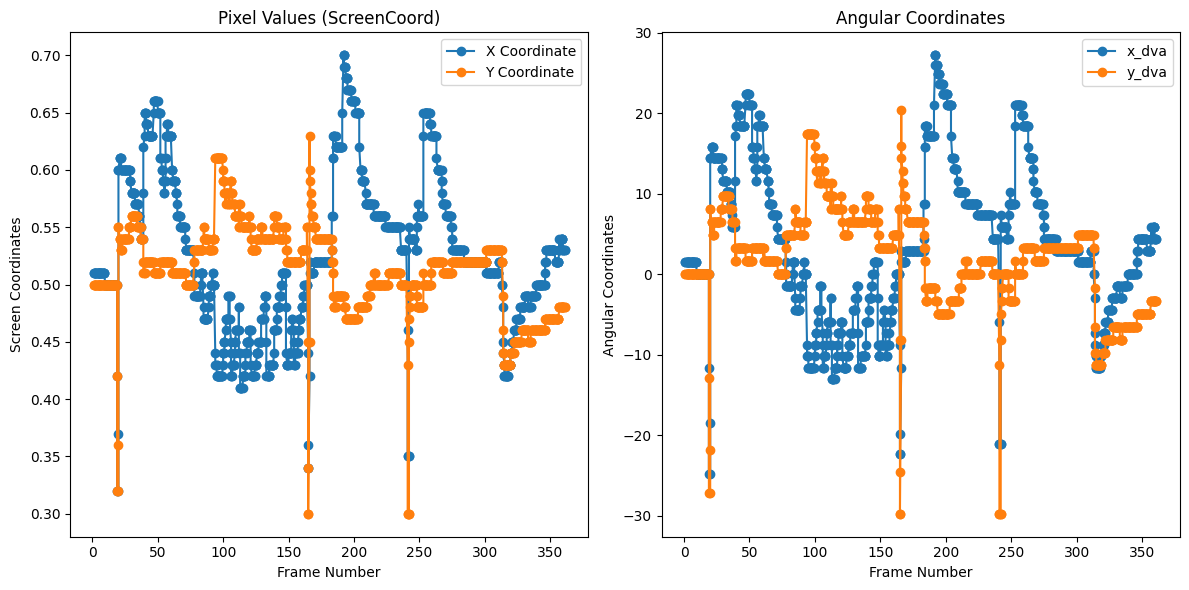

In [22]:
visualise_eh_task_data('../data/EHTaskDataset/RawData/User_01_Video_01_Task_1.txt')

In [31]:
def deg2pix(deg, screenPX, screenCM, distanceCM):
    from math import atan2, degrees
    # Converts degrees of visual angle to pixel screen coordinate
    # screenPX is the number of pixels that the monitor has in the horizontal
    # axis (for x coord) or vertical axis (for y coord)
    # screenCM is the width of the monitor in centimeters
    # distanceCM is the distance of the monitor to the retina
    # pix: screen coordinate in pixels
    # adjust origin: if origin (0,0) of screen coordinates is in the corner of the screen rather than in the center, set to True to center coordinates
    deg = np.array(deg)

    deg_per_px = degrees(atan2(.5 * screenCM, distanceCM)) / (.5 * screenPX)
    return deg / deg_per_px


# convert deg to px
def deg2pix_xy(data, screen_config={'resolution': [1680, 1050],
                                    'screen_size': [47.4, 29.7],
                                    'distance': 55.5,
                                    'sampling_rate': 1000}):
    from math import atan2, degrees
    # Converts degrees of visual angle to pixel screen coordinate
    data_copy = data.copy()
    pix = np.zeros(data_copy.shape)
    for i in range(data_copy.shape[2]):
        pix[:, :, i] = deg2pix(data_copy[:, :, i], screen_config['resolution'][i],
                               screen_config['screen_size'][i],
                               screen_config['distance'])
    return pix

In [38]:
def visualise_gazebase(file_path):
    df = pd.read_csv(file_path)
    
    df = df.head(1200)
    
    x = df['x']
    y = df['y']
    n_values = df['n']
    
    screen_config={'resolution': [1680, 1050],
                       'screen_size': [47.4, 29.7],
                       'distance': 55.5}
    X = np.array([
            x,
            y,
        ]).T
    X_px = X.copy()
    X_px[:, 0] = deg2pix(X_px[:, 0],
                         screen_config['resolution'][0],
                         screen_config['screen_size'][0],
                         screen_config['distance'])
    # adjust origin
    X_px[:, 0] += screen_config['resolution'][0] / 2

    X_px[:, 1] = deg2pix(X_px[:, 1],
                         screen_config['resolution'][1],
                         screen_config['screen_size'][1],
                         screen_config['distance'])
    # adjust origin
    X_px[:, 1] += screen_config['resolution'][1] / 2
    print(X_px.shape)
    
    # Create plots
    plt.figure(figsize=(12, 6))
    
    # Plot pixel values (ScreenCoord)
    plt.subplot(1, 2, 1)
    plt.plot(n_values, X_px[:, 0], label='X Coordinate', marker='o')
    plt.plot(n_values, X_px[:, 1], label='Y Coordinate', marker='o')
    plt.xlabel('n_values')
    plt.ylabel('Pixel Values')
    plt.title('Pixel Values Gazebase')
    plt.legend()
    
    # Plot Angular Coordinates
    plt.subplot(1, 2, 2)
    plt.scatter(n_values, x, label='x_dva', marker='o')
    plt.scatter(n_values, y, label='y_dva', marker='x')
    
    plt.xlabel('n')
    plt.ylabel('dva')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

(1200, 2)


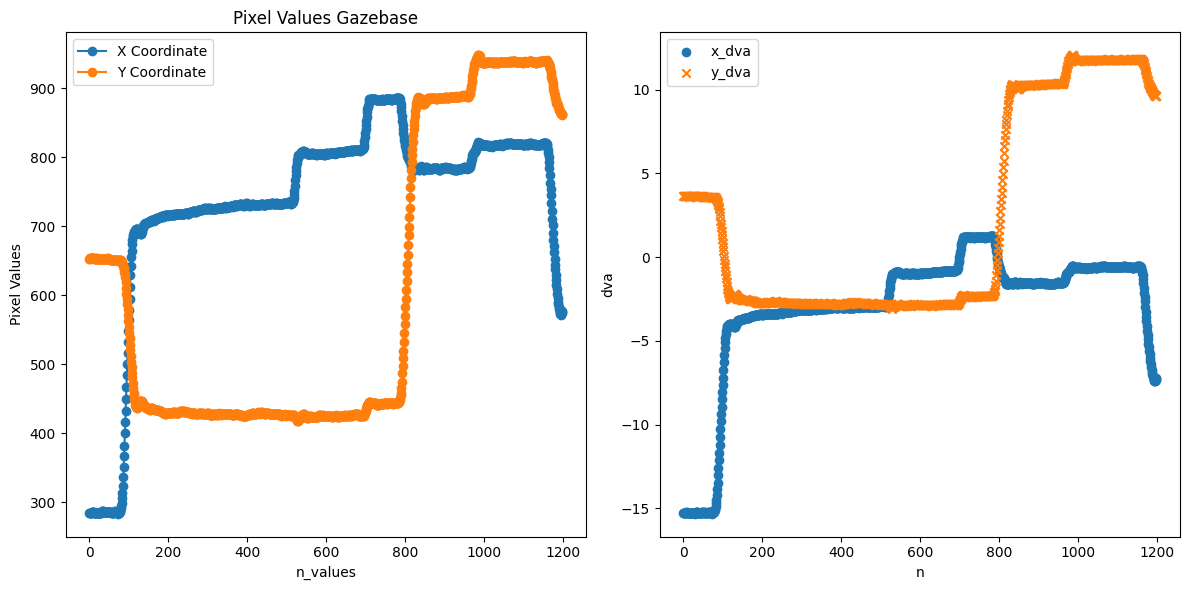

In [39]:
visualise_gazebase('../data/GazeBase/raw/Round_1/Subject_1001/S1/S1_Reading/S_1001_S1_TEX.csv')

In [1]:
def plot_fixations(file_path):
    fixation_matrix = np.load(file_path) # shape(n, 100, 6)
    column_dict = {'x_dva': 0, 'y_dva': 1, 'x_px': 2, 'y_px': 3, 'x_dva_vel': 4, 'y_dva_vel': 5}
    n = 100
    # (shape: (n, 100, 6))
    first_n_fixations = fixation_matrix[:n]
    
    plt.figure(figsize=(8, 6))
    
    # Plot each fixation's trajectory on the same plot
    for i in range(n):
        x_dva = first_n_fixations[i, :, column_dict['x_dva']]
        y_dva = first_n_fixations[i, :, column_dict['y_dva']]
        
        plt.plot(x_dva, y_dva, marker='o', linestyle='-', markersize=2, label=f'Fixation {i+1}')
    
    plt.title('Trajectories of First n Fixations')
    plt.xlabel('X (dva)')
    plt.ylabel('Y (dva)')
    # plt.legend()
    plt.grid(True)
    
    plt.show()

    print(fixation_matrix.shape)

In [75]:
def plot_saccades(file_path):
    saccade_matrix = np.load(file_path)
    print(saccade_matrix.shape)
    saccade_matrix = np.load(file_path) # shape(n, 100, 6)
    column_dict = {'x_dva': 0, 'y_dva': 1, 'x_px': 2, 'y_px': 3, 'x_dva_vel': 4, 'y_dva_vel': 5}
    n = 100
    # (shape: (n, 100, 6))
    first_n_saccades = saccade_matrix[:n]
    
    plt.figure(figsize=(8, 6))
    
    # Plot each fixation's trajectory on the same plot
    for i in range(n):
        # Extract x and y coordinates for the fixation
        x_dva = first_n_saccades[i, :, column_dict['x_dva']]
        y_dva = first_n_saccades[i, :, column_dict['y_dva']]
        
        plt.plot(x_dva, y_dva, marker='o', linestyle='-', markersize=2, label=f'Saccade {i+1}')
    
    plt.title('Trajectories of first_n_saccades')
    plt.xlabel('X (dva)')
    plt.ylabel('Y (dva)')
    # plt.legend()
    plt.grid(True)
    
    plt.show()

    print(fixation_matrix.shape)

In [2]:
plot_fixations('../data/fixation_matrix_gazebase_vd_text.npy')

NameError: name 'np' is not defined

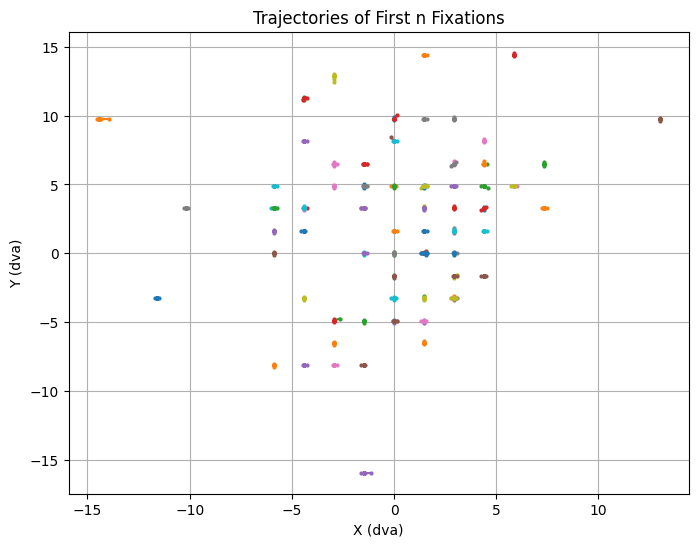

(2280, 100, 6)


In [69]:
plot_fixations('../data/fixation_matrix_ehtask_vd.npy')

(29665, 30, 6)


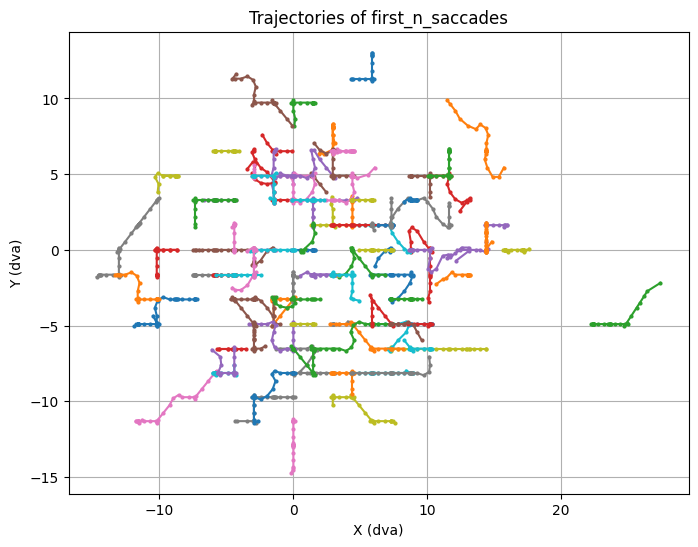

(2280, 100, 6)


In [76]:
plot_saccades('../data/saccade_matrix_ehtask_vd.npy')

(103883, 30, 6)


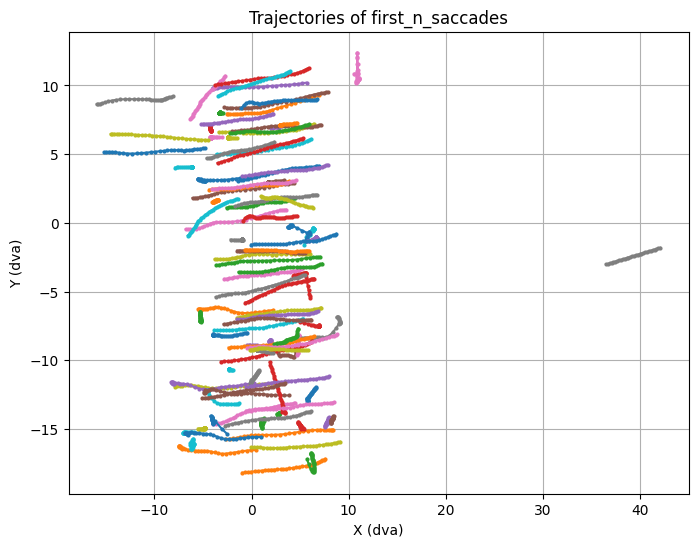

(2280, 100, 6)


In [77]:
plot_saccades('../data/saccade_matrix_gazebase_vd_text.npy')

In [3]:
fixation_matrix = np.load('../data/fixation_matrix_gazebase_vd_text.npy')
#fixation_matrix = np.load('../data/fixation_matrix_ehtask_vd.npy')

In [4]:
fixation_matrix.shape

(393711, 100, 6)

In [5]:
fixation_matrix[:20].shape

(20, 100, 6)

In [12]:
data_shape = fixation_matrix.shape
tmp = np.any(data_shape != (data_shape[0], 100, 6))
len(fixation_matrix[345])

100

In [54]:
fixation_matrix[0]

array([[ 1.40243719e+00,  1.63609223e+00,  0.00000000e+00,
         0.00000000e+00,  2.62956972e-01, -8.32667268e-17],
       [ 1.61280276e+00,  1.63609223e+00,  0.00000000e+00,
         0.00000000e+00,  1.57774183e-01, -8.32667268e-17],
       [ 1.47255904e+00,  1.63609223e+00,  0.00000000e+00,
         0.00000000e+00, -8.32667268e-17, -8.32667268e-17],
       [ 1.47255904e+00,  1.63609223e+00,  0.00000000e+00,
         0.00000000e+00, -8.32667268e-17, -8.32667268e-17],
       [ 1.47255904e+00,  1.63609223e+00,  0.00000000e+00,
         0.00000000e+00, -8.32667268e-17, -8.32667268e-17],
       [ 1.47255904e+00,  1.63609223e+00,  0.00000000e+00,
         0.00000000e+00, -8.32667268e-17, -8.32667268e-17],
       [ 1.47255904e+00,  1.63609223e+00,  0.00000000e+00,
         0.00000000e+00, -8.32667268e-17, -8.32667268e-17],
       [ 1.47255904e+00,  1.63609223e+00,  0.00000000e+00,
         0.00000000e+00, -8.32667268e-17, -8.32667268e-17],
       [ 1.47255904e+00,  1.63609223e+00,  0.000

In [78]:
sm = np.load('../data/saccade_matrix_ehtask_vd.npy')
sm.shape

(29665, 30, 6)

In [67]:
sm[0]

array([[-1.40243719e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.57774183e-01, -0.00000000e+00],
       [ 7.01218593e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  2.62956972e-01, -0.00000000e+00],
       [ 4.90853015e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  3.15548367e-01, -0.00000000e+00],
       [ 9.81706030e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  3.15548367e-01, -0.00000000e+00],
       [ 1.40243719e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  2.62956972e-01, -0.00000000e+00],
       [ 1.61280276e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.57774183e-01, -0.00000000e+00],
       [ 1.47255904e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -8.32667268e-17, -0.00000000e+00],
       [ 1.47255904e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -8.32667268e-17, -0.00000000e+00],
       [ 1.47255904e+00,  0.00000000e+00,  0.000

In [81]:
sm = np.load('../data/saccade_matrix_gazebasevr_vd_text.npy')
sm.shape

(103883, 30, 6)

In [82]:
sm[0]

array([[-1.51905705e+01,  5.14189090e+00,  3.16414032e+02,
         7.05884501e+02,  1.95007000e-01,  1.00216429e-02],
       [-1.49760391e+01,  5.15539210e+00,  3.28450290e+02,
         7.05474759e+02,  2.35614357e-01,  6.88996429e-03],
       [-1.47228946e+01,  5.16666667e+00,  3.43645621e+02,
         7.03938023e+02,  2.81125643e-01, -1.04403571e-03],
       [-1.44187105e+01,  5.16179529e+00,  3.59097416e+02,
         7.02810960e+02,  3.25953536e-01, -1.14839643e-02],
       [-1.40689111e+01,  5.14258724e+00,  3.76024854e+02,
         7.01478833e+02,  3.68754929e-01, -2.17158214e-02],
       [-1.36699582e+01,  5.10709057e+00,  3.93116886e+02,
         7.01581313e+02,  4.07204571e-01, -2.57879286e-02],
       [-1.32369037e+01,  5.07117414e+00,  4.10679489e+02,
         7.02093675e+02,  4.37020786e-01, -2.20297500e-02],
       [-1.27737430e+01,  5.04486229e+00,  4.27996417e+02,
         7.02913440e+02,  4.58863321e-01, -1.28420000e-02],
       [-1.23026963e+01,  5.03985010e+00,  4.455

In [84]:
data = sm
train_data = data[:,:,4:6]

In [85]:
train_data.shape

(103883, 30, 2)

In [13]:
sm = np.load('../data/saccade_matrix_gazebasevr_vd_text.npy')
sm.shape

(47252, 30, 6)

In [5]:
fm = np.load('../data/fixation_matrix_gazebasevr_vd_text.npy')
fm.shape

(26780, 10, 6)

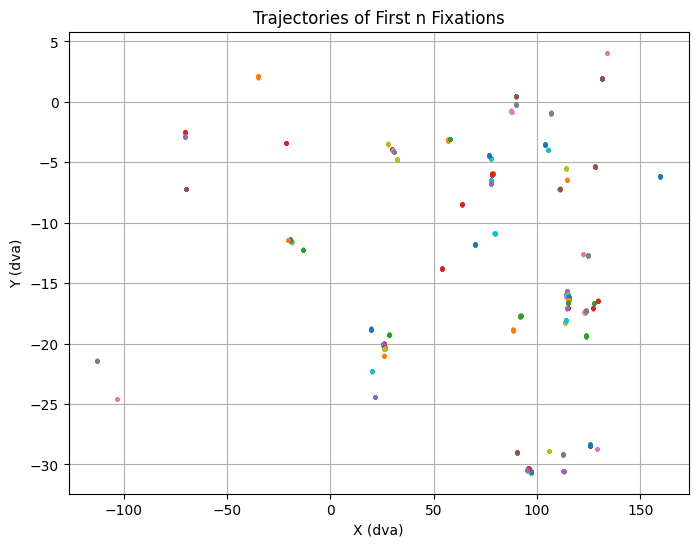

(26780, 10, 6)
